 ## 파이썬 세션 3.2.2 : 투자전략 예시 벤저민 그레이엄

In [3]:
# 필요 라이브러리 가져오기 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_columns', None)

OptionError: 'Pattern matched multiple keys'

# Load data

- 데이터 출처: 증권사 API, N사 금융, 금투협, 유료 데이터 벤더
- 이때 데이터 클리닝, EDA와 같은 작업 방법은 세션 외의 내용인 것 같아 설명을 생략하겠습니다. 
- Load data 파트는 이해하기 보다는 그냥 받아들여주세요.

In [2]:
# 코드를 돌릴 때 warning이 안나오게 하기
import warnings
warnings.filterwarnings('ignore')

In [5]:
# csv파일 불러오기 : fin_statement_new.csv
# 앞부분을 보며 내용 확인하기 

df = pd.read_csv("fin_statement_new.csv")
df.head()

,Code,Name,결산월,상장일,시가총액,유통시가총액,"P/E(Adj., FY End)","P/B(Adj., FY End)","P/S(Adj., FY End)","P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,"DPS(보통주, 현금+주식, 연간)",year,수정주가,ROA,비유동부채,자산총계
0,A000020,동화약품,12,19760324,113122453500.000,65520525067.000,11.230,0.550,0.560,4.390,3.480,4.390,600.000,2006,6460,3.810,11961630.000,195293494.000
1,A000040,KR모터스,12,19760525,144125742600.000,111855988832.000,97.070,1.440,0.820,-7.780,16.840,40.670,0.000,2006,1098,-21.980,28190608.000,81250312.000
2,A000050,경방,12,19560303,275600000000.000,180269960000.000,426.230,0.860,2.010,5.780,15.340,20.660,0.000,2006,10339,-1.800,17344611.000,515345506.000
3,A000070,삼양홀딩스,12,19681227,602432236800.000,281576827480.000,8.360,0.570,0.530,11.160,4.600,6.210,1050.000,2006,63563,5.490,60878366.000,973804019.000
4,A000100,유한양행,12,19621101,1382097577000.000,1018467704491.000,25.280,2.670,4.070,-27.990,15.720,17.160,1000.000,2006,24911,7.530,95212024.000,746417156.000


In [6]:
# 이름을 깔끔하게 바꿔주기
# 다시 한 번 확인하기 

df = df.rename(columns={
    "DPS(보통주, 현금+주식, 연간)": "DPS",
    "P/E(Adj., FY End)": "PER",
    "P/B(Adj., FY End)": "PBR",
    "P/S(Adj., FY End)": "PSR",
})

df.head()

,Code,Name,결산월,상장일,시가총액,유통시가총액,PER,PBR,PSR,"P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,DPS,year,수정주가,ROA,비유동부채,자산총계
0,A000020,동화약품,12,19760324,113122453500.000,65520525067.000,11.230,0.550,0.560,4.390,3.480,4.390,600.000,2006,6460,3.810,11961630.000,195293494.000
1,A000040,KR모터스,12,19760525,144125742600.000,111855988832.000,97.070,1.440,0.820,-7.780,16.840,40.670,0.000,2006,1098,-21.980,28190608.000,81250312.000
2,A000050,경방,12,19560303,275600000000.000,180269960000.000,426.230,0.860,2.010,5.780,15.340,20.660,0.000,2006,10339,-1.800,17344611.000,515345506.000
3,A000070,삼양홀딩스,12,19681227,602432236800.000,281576827480.000,8.360,0.570,0.530,11.160,4.600,6.210,1050.000,2006,63563,5.490,60878366.000,973804019.000
4,A000100,유한양행,12,19621101,1382097577000.000,1018467704491.000,25.280,2.670,4.070,-27.990,15.720,17.160,1000.000,2006,24911,7.530,95212024.000,746417156.000


In [7]:
# 연도별 상장 종목 수 알아보기 
df.groupby(['year'])['Name'].count()

year
2006    1479
2007    1538
2008    1606
2009    1636
2010    1623
2011    1634
2012    1653
2013    1643
2014    1655
2015    1692
2016    1771
2017    1838
Name: Name, dtype: int64

In [8]:
# 기업이 몇 년간 있는가 (상장폐지 여부, 언제 상장되었는지를 알 수 있다.)
df.groupby(['Name'])['year'].count()

Name
3S        12
3SOFT      4
3노드디지탈     6
AD모터스      7
AJS        9
          ..
흥국         8
흥국에프엔비     2
흥아해운      12
희림        12
희훈디앤지      4
Name: year, Length: 2241, dtype: int64

In [9]:
# code or name의 중복 체킹 방법
# 연도별로 유니크한 이름(주식이름)이 몇 개인지 세고
# 연도별로 유니크한 종목번호이 몇 개인지 비교하여 같으면 True 출력 

df.groupby(['year'])['Name'].nunique().equals(df.groupby(['year'])['Code'].nunique())

True

# yearly returns

In [10]:
# 동화약품의 매년 말 주가 확인해보기

df[df['Name'] == '흥국']

,Code,Name,결산월,상장일,시가총액,유통시가총액,PER,PBR,PSR,"P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,DPS,year,수정주가,ROA,비유동부채,자산총계
6646,A010240,흥국,12,20090512,25877661600.000,10542559336.000,-200.390,1.340,0.820,-34.770,24.820,80.320,150.000,2010,2190,10.510,508842.000,26356772.000
8267,A010240,흥국,12,20090512,32839984840.000,13585901728.000,5.650,1.070,0.440,-5.070,5.040,5.630,150.000,2011,2335,-0.470,2298652.000,28331927.000
9902,A010240,흥국,12,20090512,31361261320.000,13654693179.000,4.080,0.710,0.270,-1.880,5.160,5.830,150.000,2012,1927,13.960,3435291.000,40037859.000
11549,A010240,흥국,12,20090512,23751996540.000,10434252080.000,6.740,0.560,0.260,4.650,5.450,8.690,100.000,2013,2040,10.140,30071928.000,77762295.000
13188,A010240,흥국,12,20090512,25230720060.000,11134316762.000,7.720,0.560,0.320,4.500,5.290,9.480,100.000,2014,1737,3.930,25938687.000,79992886.000
14836,A010240,흥국,12,20090512,26124115520.000,11578207998.000,12.820,0.470,0.290,5.300,5.630,12.870,100.000,2015,2200,3.750,14350866.000,73024970.000
16529,A010240,흥국,12,20090512,28434621020.000,12724492906.000,19.220,0.580,0.420,4.180,6.290,17.550,150.000,2016,4945,2.050,17656678.000,70266509.000
18298,A010240,흥국,12,20090512,52001777120.000,24347232048.000,16.840,1.230,0.970,10.730,7.760,14.190,250.000,2017,3530,1.850,6648721.000,66103992.000


In [11]:
# pivot을 통해 새로운 테이블 만들기 
yearly_price_df = df.pivot(index="year", columns="Name", values="수정주가")

# 출력해보기 
yearly_price_df.head()

Name,3S,3SOFT,3노드디지탈,AD모터스,AJS,AJ네트웍스,AJ렌터카,AK홀딩스,APS홀딩스,AP시스템,...,휴온스,휴온스글로벌,휴젤,휴켐스,흥구석유,흥국,흥국에프엔비,흥아해운,희림,희훈디앤지
year,,,,,,,,,,,,,,,,,,,,,
2006,830.000,6530.000,NaN,1997.000,1250.000,NaN,NaN,12960.000,2940.000,NaN,...,NaN,NaN,NaN,5356.000,1976.000,NaN,NaN,1979.000,2941.000,1212.000
2007,686.000,5410.000,NaN,1600.000,2200.000,NaN,NaN,26015.000,2607.000,NaN,...,NaN,6385.000,NaN,11430.000,3393.000,NaN,NaN,3011.000,8072.000,1120.000
2008,524.000,930.000,799.000,244.000,835.000,NaN,NaN,8859.000,2566.000,NaN,...,NaN,4538.000,NaN,13179.000,2420.000,NaN,NaN,1053.000,7687.000,210.000
2009,1163.000,5.000,1770.000,911.000,2820.000,NaN,NaN,10362.000,3185.000,NaN,...,NaN,5549.000,NaN,18336.000,2660.000,NaN,NaN,1151.000,11000.000,5.000
2010,3237.000,NaN,1840.000,718.000,1740.000,NaN,NaN,22039.000,5692.000,NaN,...,NaN,4206.000,NaN,19600.000,2320.000,2190.000,NaN,1935.000,8320.000,NaN


- rtn 구하기
    - $p_{n+1}\over{p_{n}}$ - 1

In [12]:
# 수익률을 계산하고 저장하기
# 데이터를 "xx년도에서 1년동안 들고있었더니, xx만큼 수익이 났다"를 의미
yearly_rtn_df = yearly_price_df.pct_change(fill_method=None).shift(-1)

# 출력해보기
yearly_rtn_df.head()

Name,3S,3SOFT,3노드디지탈,AD모터스,AJS,AJ네트웍스,AJ렌터카,AK홀딩스,APS홀딩스,AP시스템,...,휴온스,휴온스글로벌,휴젤,휴켐스,흥구석유,흥국,흥국에프엔비,흥아해운,희림,희훈디앤지
year,,,,,,,,,,,,,,,,,,,,,
2006,-0.173,-0.172,NaN,-0.199,0.760,NaN,NaN,1.007,-0.113,NaN,...,NaN,NaN,NaN,1.134,0.717,NaN,NaN,0.521,1.745,-0.076
2007,-0.236,-0.828,NaN,-0.848,-0.620,NaN,NaN,-0.659,-0.016,NaN,...,NaN,-0.289,NaN,0.153,-0.287,NaN,NaN,-0.650,-0.048,-0.812
2008,1.219,-0.995,1.215,2.734,2.377,NaN,NaN,0.170,0.241,NaN,...,NaN,0.223,NaN,0.391,0.099,NaN,NaN,0.093,0.431,-0.976
2009,1.783,NaN,0.040,-0.212,-0.383,NaN,NaN,1.127,0.787,NaN,...,NaN,-0.242,NaN,0.069,-0.128,NaN,NaN,0.681,-0.244,NaN
2010,6.677,NaN,-0.504,-0.458,-0.353,NaN,NaN,0.154,0.702,NaN,...,NaN,0.306,NaN,0.018,-0.353,0.066,NaN,-0.372,-0.242,NaN


## 함수화

In [13]:
# 수익률 계산을 위한 함수 정의

def get_return_series(selected_return_df):
    rtn_series = selected_return_df.mean(axis=1)
    rtn_series.loc[2005] = 0    
    rtn_series = rtn_series.sort_index()

    cum_rtn_series = (rtn_series + 1).cumprod().dropna()
    return rtn_series, cum_rtn_series

In [14]:
# 수익률의 그래프를 그려주는 함수 정의 

def plot_return(cum_rtn_series, rtn_series):
    fig, axes = plt.subplots(nrows=2, figsize=(15, 6), sharex=True)
    axes[0].plot(cum_rtn_series.index, cum_rtn_series, marker='o');
    axes[1].bar(rtn_series.index, rtn_series);
    axes[0].set_title("Cum return(line)");
    axes[1].set_title("Yearly return(bar)");

## 투자전략 예시. 벤자민 그레이엄

- Filter: 기준이긴 하지만 직접적으로 최종 종목 선정에 영향을 주지 않는 것 
    - ROA 5% 이상
    - 부채비율 50% 이하
- Select: 기준임과 동시에 직접적으로 최종 종목 선정에 영향을 주는 것 
    - (PBR 0.2 이상)
    - PBR 낮은기업 15개 매수

### Filter

In [15]:
# ROA >= 0.05인 것을 필터링하여 새롭게 변수로 정의하기
filtered_df = df[df['ROA'] >= 0.05]

In [16]:
# 부채비율 <= 0.5인 것을 필터링하여 새롭게 변수로 정의하기
filtered_df['부채비율'] = filtered_df['비유동부채'] / filtered_df['자산총계']

In [17]:
# 두 조건을 And로 적용하여 연결하기
filtered_df = filtered_df[filtered_df['부채비율'] <= 0.5]

### Selector

In [18]:
# 앞에서 filter한 데이터 프레임에서  
# PBR이 0.2보다 크거나 같은 것들을 다시 뽑아냄
filtered_df = filtered_df[filtered_df['PBR'] >= 0.2]

In [19]:
# 연도별로 PBR이 낮은 순 15개를 뽑아내기 
smallest_pbr_series = filtered_df.groupby("year")['PBR'].nsmallest(15)

# 출력해보기 
smallest_pbr_series.index

MultiIndex([(2006,   121),
            (2006,   174),
            (2006,  1244),
            (2006,   176),
            (2006,   542),
            (2006,   551),
            (2006,   130),
            (2006,   274),
            (2006,   293),
            (2006,   487),
            ...
            (2017, 18124),
            (2017, 19363),
            (2017, 18014),
            (2017, 18028),
            (2017, 18396),
            (2017, 18955),
            (2017, 18073),
            (2017, 17953),
            (2017, 18306),
            (2017, 18075)],
           names=['year', None], length=180)

In [20]:
# 선정된 것들을 인덱스 형태로 새롭게 지정 
selected_index = smallest_pbr_series.index.get_level_values(1)

In [21]:
# 필터링 하고 출력해보기 (최종적으로 선정된 주식들)
filtered_df.loc[selected_index]

,Code,Name,결산월,상장일,시가총액,유통시가총액,PER,PBR,PSR,"P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,DPS,year,수정주가,ROA,비유동부채,자산총계,부채비율
121,A002670,미주제강,12,19960701,34808592000.000,23321756640.000,5.790,0.200,0.060,-3.670,8.470,15.330,0.000,2006,835,16.210,15349579.000,86224762.000,0.178
174,A003780,진양산업,12,19730626,34598400000.000,18541282560.000,11.220,0.210,0.760,5.240,6.340,9.210,50.000,2006,571,2.380,7997698.000,94485573.000,0.085
1244,A058900,투미비티,12,20041029,42579000000.000,37005408900.000,-0.760,0.210,0.130,3.130,-17.690,-8.630,0.000,2006,27246,8.030,279325.000,17166526.000,0.016
176,A003830,대한화섬,12,19851223,93225600000.000,27678680640.000,5.090,0.220,0.300,1.890,1.490,2.830,750.000,2006,121500,1.420,1623648.000,326318710.000,0.005
542,A016380,동부제철,12,19860203,283733902400.000,109237552424.000,13.720,0.220,0.090,5.600,5.540,12.280,100.000,2006,633429,5.560,283855450.000,2245220779.000,0.126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18955,A058650,세아홀딩스,12,20010730,532000000000.000,53200000000.000,5.730,0.300,0.130,2.740,4.060,7.420,2000.000,2017,152000,4.440,70862406.000,980431299.000,0.072
18073,A003240,태광산업,12,19751227,1329399600000.000,432985449720.000,73.750,0.310,0.390,5.270,1.370,4.300,1925.000,2017,1317000,2.720,100315979.000,2545069165.000,0.039
17953,A000500,가온전선,12,19870608,98808241250.000,56103319382.000,24.120,0.330,0.120,2.420,9.080,16.940,600.000,2017,22950,0.410,80513598.000,489897296.000,0.164
18306,A010660,화천기계,12,19881212,47080000000.000,26110568000.000,-18.970,0.350,0.240,5.850,-82.760,-1.970,100.000,2017,2170,1.350,2158530.000,159783820.000,0.014


In [22]:
# 그 후 loc를 활용하여 인덱싱을 진행

selector_df = filtered_df.loc[selected_index].pivot(
    index='year', columns="Name", values="PBR"
)

# 출력해보기
selector_df.head()

Name,CS홀딩스,DB하이텍,E1,KD건설,KISCO홀딩스,NICE평가정보,POSCO,SG세계물산,SIMPAC Metal,TBH글로벌,...,한국제지,한라,한일시멘트,현대시멘트,형지I&C,화성산업,화승알앤에이,화승인더,화천기계,휴스틸
year,,,,,,,,,,,,,,,,,,,,,
2006,NaN,NaN,NaN,0.250,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.240,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.250,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,0.360,NaN,NaN,NaN,0.280,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.310,NaN,NaN,NaN,0.320,NaN,NaN
2009,NaN,NaN,NaN,NaN,0.200,0.200,NaN,NaN,NaN,0.210,...,NaN,0.210,NaN,NaN,NaN,NaN,0.200,NaN,NaN,NaN
2010,NaN,NaN,NaN,NaN,NaN,0.210,NaN,0.230,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# 백테스팅 진행. 해당 기준으로 손익의 상황 파악하기
asset_on_df = selector_df.notna().astype(int).replace(0, np.nan)
selected_return_df = yearly_rtn_df * asset_on_df

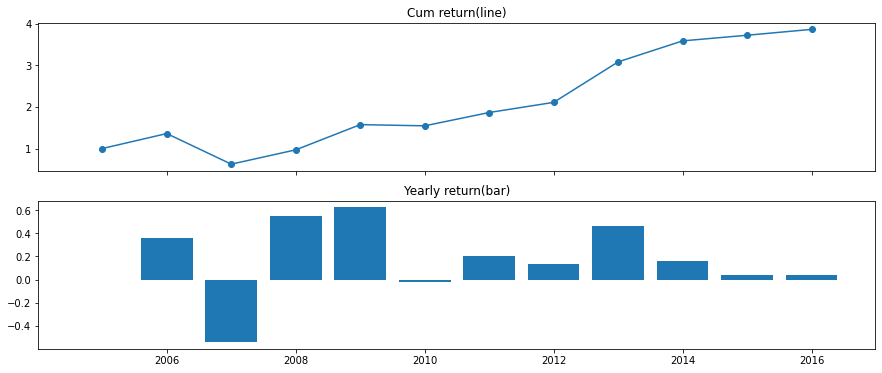

In [24]:
# 그래프 그려보기 
rtn_series, cum_rtn_series = get_return_series(selected_return_df)
plot_return(cum_rtn_series, rtn_series)

## Extra. 소형주 + 저PBR 전략

- Filter
    - 소형주(시가총액 하위 20%)

- Select
    - PBR 0.2 이상
    - PBR이 가장 낮은 주식순으로 15개 매수

### Filter


In [25]:
# 연도별로 시가총액을 quantile로 구하기
market_cap_quantile_series = df.groupby("year")['시가총액'].quantile(.2)

# 출력해보기 연도별 하위 20%의 시가총액을 의미한다. 
market_cap_quantile_series

year
2006   24661836580.000
2007   28279300000.000
2008   24283951632.000
2009   17405536920.000
2010   25180324846.000
2011   28192790880.000
2012   30077589803.000
2013   33819166404.000
2014   35391903298.400
2015   46836178000.000
2016   54850060350.000
2017   61753217430.000
Name: 시가총액, dtype: float64

In [26]:
# 왼쪽을 기준으로 join 해준다.year 값이 인덱스로 들어간다. 
filtered_df = df.join(market_cap_quantile_series, on="year", how="left", rsuffix="20%_quantile")

In [27]:
# 필터링 작업을 해주기
filtered_df = filtered_df[filtered_df['시가총액'] <= filtered_df['시가총액20%_quantile']]

# 출력해보기
filtered_df.head()

,Code,Name,결산월,상장일,시가총액,유통시가총액,PER,PBR,PSR,"P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,DPS,year,수정주가,ROA,비유동부채,자산총계,시가총액20%_quantile
21,A000440,중앙에너비스,12,19960701,15198600000.000,5828663100.000,12.560,0.370,0.170,15.080,7.600,10.190,800.000,2006,5234,3.470,4359080.000,51819700.000,24661836580.000
34,A000760,이화산업,12,19940429,11158000000.000,5161690800.000,-0.980,0.270,0.180,-9.360,-5.830,-5.530,0.000,2006,3965,-9.840,1457925.000,93661256.000,24661836580.000
40,A000910,유니온,12,19960703,19769831000.000,8811413677.000,22.400,0.320,0.370,5.070,6.730,18.710,500.000,2006,1632,0.660,4516111.000,95440233.000,24661836580.000
44,A001000,신라섬유,12,19960701,15450000000.000,8503680000.000,-53.000,1.680,14.950,-13.330,-72.110,-59.790,0.000,2006,1120,0.300,25672808.000,39723341.000,24661836580.000
52,A001140,국보,12,19891202,9553927200.000,6067699165.000,258.790,0.550,0.140,3.660,6.750,17.780,0.000,2006,800,0.870,12534042.000,71494973.000,24661836580.000


### Selector

In [28]:
# 앞에서 filter한 데이터 프레임에서  
# PBR이 0.2보다 크거나 같은 것들을 다시 뽑아냄 
filtered_df = filtered_df[filtered_df['PBR'] >= 0.2]

In [29]:
# PBR이 작은 순으로 15개를 뽑아냄 
smallest_pbr_series = filtered_df.groupby("year")['PBR'].nsmallest(15)

# 출력해보기 
smallest_pbr_series.index

MultiIndex([(2006,   882),
            (2006,   359),
            (2006,   433),
            (2006,  1012),
            (2006,   341),
            (2006,   703),
            (2006,  1241),
            (2006,    34),
            (2006,    76),
            (2006,   320),
            ...
            (2017, 18191),
            (2017, 18306),
            (2017, 18501),
            (2017, 19758),
            (2017, 18257),
            (2017, 18546),
            (2017, 18015),
            (2017, 18188),
            (2017, 18043),
            (2017, 18712)],
           names=['year', None], length=180)

In [30]:
# 선정된 것들을 인덱스 형태로 새롭게 지정 
selected_index = smallest_pbr_series.index.get_level_values(1)

# 필터링 하고 출력해보기 (최종적으로 선정된 주식들)
filtered_df.loc[selected_index]

,Code,Name,결산월,상장일,시가총액,유통시가총액,PER,PBR,PSR,"P/FCF1(Adj., FY End)",EV/EBITDA,EV/EBIT,DPS,year,수정주가,ROA,비유동부채,자산총계,시가총액20%_quantile
882,A037240,평안물산,12,19991214,21150000000.000,20498580000.000,-0.360,0.220,0.310,-1.850,-4.440,-4.060,0.000,2006,113846,-27.230,4493833.000,24299630.000,24661836580.000
359,A008830,대동기어,12,19960701,7190019200.000,3925750483.000,19.210,0.250,0.080,0.900,3.000,13.610,250.000,2006,1842,1.190,8026964.000,58404722.000,24661836580.000
433,A011300,성안,12,19951110,17626077700.000,10750144789.000,44.760,0.250,0.230,3.010,9.790,16.140,0.000,2006,329,3.520,6863195.000,126931054.000,24661836580.000
1012,A044180,KD건설,12,20001116,23511000000.000,16793907300.000,18.050,0.250,0.180,-1.660,8.910,27.250,0.000,2006,1166603,1.250,13932463.000,45560783.000,24661836580.000
341,A008110,대동전자,3,19900605,22100000000.000,14292070000.000,26.800,0.260,0.960,-9.680,-15.950,138.700,0.000,2006,2411,-1.860,11293319.000,90318981.000,24661836580.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18546,A028080,휴맥스홀딩스,12,19970416,57856527600.000,29072905119.000,-36.020,0.400,15.650,8.900,-99.160,-97.490,NaN,2017,4640,-10.240,5060142.000,179738302.000,61753217430.000
18015,A002070,남영비비안,12,19760713,49449204000.000,9059094173.000,-25.900,0.410,0.310,-13.890,-697.120,-28.040,200.000,2017,3257,3.420,3154966.000,158952348.000,61753217430.000
18188,A006110,삼아알미늄,12,19801205,37730000000.000,17759511000.000,43.530,0.420,0.340,25.900,9.640,27.080,55.000,2017,3245,-1.740,31204930.000,188596464.000,61753217430.000
18043,A002690,동일제강,12,20150924,49500000000.000,19141650000.000,11.890,0.430,0.600,18.070,4.510,6.860,10.000,2017,3265,4.660,4833432.000,144589506.000,61753217430.000


In [31]:
# 그 후 loc를 활용하여 인덱싱을 진행
selector_df = filtered_df.loc[selected_index].pivot(
    index='year', columns="Name", values="PBR"
)
selector_df.head()

Name,CU전자,KD건설,SG충방,고려산업,광림,국동,국보,국일제지,금비,까뮤이앤씨,...,한일단조,한일철강,한일화학,한컴시큐어,현우산업,형지I&C,혜인,화승인더,화천기계,휴맥스홀딩스
year,,,,,,,,,,,,,,,,,,,,,
2006,NaN,0.250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,NaN,NaN,0.280,NaN,0.330,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,NaN,NaN,NaN,NaN,NaN,NaN,0.430,NaN,NaN,NaN,...,NaN,NaN,NaN,0.400,NaN,NaN,NaN,0.320,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,0.240,0.240,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.240,NaN,NaN,NaN,NaN
2010,NaN,NaN,NaN,0.300,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
# 백테스팅 진행. 해당 기준으로 손익의 상황 파악하기

asset_on_df = selector_df.notna().astype(int).replace(0, np.nan)
selected_return_df = yearly_rtn_df * asset_on_df

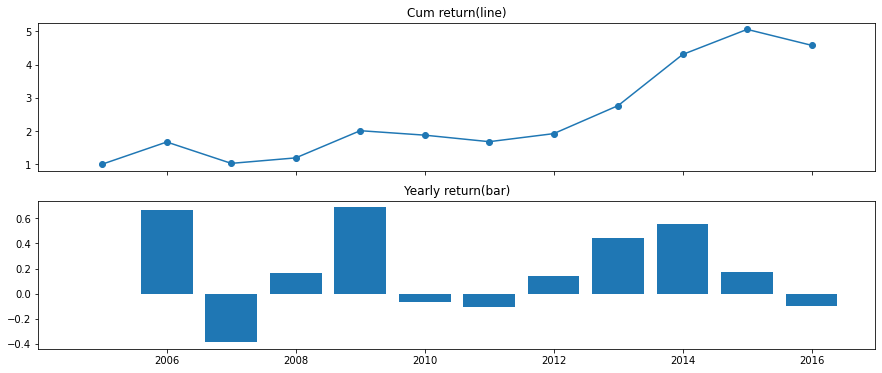

In [33]:
# 그래프 그려보기 

rtn_series, cum_rtn_series = get_return_series(selected_return_df)
plot_return(cum_rtn_series, rtn_series)